In [2]:
### Test estimating MOFA with different amount of factors to evaluate the effect of the factor amount

#############################################
# Prerequisites - Load Libraries

In [3]:
source('MS0_Libraries.r')

In [12]:
source('MS4_Plot_Config.r')

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


###############################################
# Preqrequisites Configurations & Parameters

In [13]:
data_path = '../data/current'

In [14]:
result_path = '../results/current'

In [16]:
name = 'V_FINAL_INTEGRATED'  # name of dataset to load

# Functions

In [17]:
### Function for quantile normalization

quantile_normalization = function(X){
  set.seed(42)
  ranks = apply(X, 2, rank, ties.method = 'min')  # determine ranks of each entry
  
  sorted = data.frame(apply(X, 2, sort)) # sort the entries
  means = apply(sorted, 1, mean) # calculate the means
  
  normalized_data = apply(ranks, 2 ,function(x){ means[x]}) # substitute the means into ranks matrix
}


In [18]:
### Gene wise quantile normalization

stdnorm <- function(x) {
  set.seed(42)
  r = rank(x[!is.na(x)], ties.method="average")
  x[!is.na(x)] = qnorm(r / (length(x[!is.na(x)]) + 1))
  return(x)
}

In [19]:
### Function to calculate mean difference between two groups

t_test_for_groups = function(heatmap_data, group1 = 'TP1|TP2', group2 = 'TP3|TP4', variable = 'measurement'){
    heatmap_data$group = NA
    heatmap_data$group[!is.na(str_extract(heatmap_data[,variable], group1))] = 'group1'
    heatmap_data$group[!is.na(str_extract(heatmap_data[,variable], group2))] = 'group2'
    
    t_test_result = heatmap_data %>% group_by(variable,view) %>% t_test(value~group)
    heatmap_data = merge(heatmap_data,t_test_result[,c('variable', 'view', 'p')])
    heatmap_data$variable[heatmap_data$p < 0.05/nrow(heatmap_data)] = paste0(heatmap_data$variable[heatmap_data$p < 0.05/nrow(heatmap_data)], '*')
    heatmap_data$gene[heatmap_data$p < 0.05/nrow(heatmap_data)] = paste0(heatmap_data$gene[heatmap_data$p < 0.05/nrow(heatmap_data)], '*')
    return(heatmap_data)
    }

# Load Data 

## Prepared combined data

In [20]:
path = paste0(result_path, '/E-Analysis/Combined_Data_',name,'.csv')
data_long = read.csv(path)
print(file.info(path)$mtime)

[1] "2023-10-06 16:38:54 UTC"


In [23]:
data_long$X = NULL

## Sample Data

In [25]:
sample_data = read.csv(paste0(result_path, '/00_Data_Overview/Merged_Sample_Meta_Data.csv'))

In [26]:
sample_data$CK_raw = sample_data$CK

In [27]:
sample_data$CK = log2(sample_data$CK+1)

In [28]:
sample_data$Troponin = log2(sample_data$Troponin+1)

In [29]:
sample_data$CK_MB = log2(as.numeric(sample_data$CK_MB)+1)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [30]:
sample_data$CRP =  log2(as.numeric(sample_data$CRP)+1)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [31]:
sample_data$sample_id[(sample_data$sample_id == 'm13.2')  & (sample_data$library %in%  c('L6'))] = 'm13.22'

In [32]:
sample_data$sample_id[(sample_data$sample_id == 'm6.4')  & (sample_data$library %in%  c('L10'))] = 'm6.42'

In [33]:
sample_data$sample_id[(sample_data$sample_id == 'm6.1')  & (sample_data$library %in%  c('L3'))] = 'm6.12'

## Nichenet data (for specifying ligands)

In [34]:
ligand_target_matrix = readRDS(url("https://zenodo.org/record/3260758/files/ligand_target_matrix.rds"))  # gene-gene regulatory scores
# gives the regulatory potential of a target gene based on the ligand-tf & tf- target-gene links and weights of the signaling and gr network (multiply PPR of each ligand -tf  pair with the weights of the gr network)

In [35]:
### Generate data in long format

In [36]:
ligand_target_matrix_long = melt(ligand_target_matrix)

Warning message in melt(ligand_target_matrix):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(ligand_target_matrix). In the next version, this warning will become an error.”


In [37]:
colnames(ligand_target_matrix_long) = c('target', 'ligand', 'regulatory_potential')

In [38]:
head(ligand_target_matrix_long,2)

,target,ligand,regulatory_potential
,<fct>,<fct>,<dbl>
1,A1BG,CXCL1,0.0003534343
2,A1BG-AS1,CXCL1,0.0001650894


In [39]:
ligands = unique(ligand_target_matrix_long$ligand)

In [40]:
head(ligands)

[1] CXCL1 CXCL2 CXCL3 CXCL5 PPBP  CXCL6
688 Levels: CXCL1 CXCL2 CXCL3 CXCL5 PPBP CXCL6 CXCL8 CXCL9 CXCL10 ... PCDHA12

# Train MOFA Model

In [41]:
length(unique(data_long$variable))

[1] 13282

## Prepare data list

In [42]:
length(unique(data_long$sample_id))

[1] 128

In [43]:
final_data_long_backup = data_long

In [44]:
final_data_long = final_data_long_backup

In [45]:
final_data_long$cell_type = NULL

In [46]:
final_data_long$variable_transformed = NULL

In [47]:
final_data_long$type[ final_data_long$type == 'single_cell'] = str_extract(final_data_long$variable[ final_data_long$type == 'single_cell'] , '.*__')

In [48]:
final_data_long$config = NULL

In [49]:
final_data_long$X = NULL

In [50]:
head(final_data_long,2)

,sample_id,variable,value,type
,<chr>,<chr>,<dbl>,<chr>
1,k1,CK,-2.397022,clinical_data
2,k10,CK,NA,clinical_data


In [51]:
### Filter only samples measured across multiple TPs

In [52]:
samples = unique(final_data_long$sample_id)

In [53]:
unique(final_data_long$type)

[1] "clinical_data"                 "cytokine"                     
 [3] "neutrophil"                    "proteomics"                   
 [5] "X0_T.cell.CD4__"               "X1_T.cell.CD8__"              
 [7] "X10_B.cell__"                  "X11_T.cell.CD4__"             
 [9] "X12_Monocytes...CD16_FCGR3A__" "X13_Dendritic__"              
[11] "X2_T.cell.CD4__"               "X3_NK__"                      
[13] "X4_Monocytes...CD14__"         "X5_T.cell.CD4__"              
[15] "X6_Monocytes...CD14__"         "X7_Monocytes...CD14__"        
[17] "X8_B.cell__"                   "X9_Monocytes...CD16_FCGR3A__"

In [54]:
length(samples)

[1] 128

In [55]:
### Prepare data list for MOFA

In [56]:
data_list = list()

In [57]:
head(final_data_long,2)

,sample_id,variable,value,type
,<chr>,<chr>,<dbl>,<chr>
1,k1,CK,-2.397022,clinical_data
2,k10,CK,NA,clinical_data


In [58]:
nrow(final_data_long)

[1] 1700096

In [59]:
data_list= list()

In [60]:
for(i in unique(final_data_long$type)){
    data = final_data_long[final_data_long$type == i, ]
    
    data$type = NULL
    data$cell_type = NULL
    
    data = data %>% dcast(variable ~ sample_id, value  = "value")
    rownames(data) = data$variable
    colnames(data) = str_replace(colnames(data), 'value\\.', '')
    data$variable = NULL
    
    data[setdiff( samples, names(data))] = NA  # use all samples
    
    data = data[,order(colnames(data))]
    data = data[,colnames(data) %in% samples]
    
    data_list[[i]] = as.matrix(data)
    }

Warning message in dcast(., variable ~ sample_id, value = "value"):
“The dcast generic in data.table has been passed a data.frame and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(.). In the next version, this warning will become an error.”
Warning message in dcast(., variable ~ sample_id, value = "value"):
“The dcast generic in data.table has been passed a data.frame and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(.). In the next version, this warning will become an error.”
Warning message in dcast(., variable ~ sample_id, value = "value"):
“The dcast generic in data.table has been passed a data.frame and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecat

In [61]:
dim(data)

[1] 872 128

In [62]:
#str(data_list)

## Create MOFA object

### Create for own data and train

In [64]:
names(data_list) = str_replace_all(names(data_list) , '__|\\.|\\.\\.|\\.\\.\\.', '')

In [65]:
data_list_orig = data_list

In [66]:
## Adjustments for plotting overview

In [67]:
names(data_list) = str_replace(names(data_list), 'X0_TcellCD4', 'CD4+ T cells (Cluster 0)')
names(data_list) = str_replace(names(data_list), 'clinical_data', 'Clinical')
names(data_list) = str_replace(names(data_list), 'X1_TcellCD8', 'CD8+ T cells (Cluster 1)')
names(data_list) = str_replace(names(data_list), 'X10_Bcell', 'B cells (Cluster 10)')
names(data_list) = str_replace(names(data_list), 'X11_TcellCD4', 'CD4+ T cells (Cluster 11)')
names(data_list) = str_replace(names(data_list), 'X12_MonocytesCD16_FCGR3A', 'FCGR3A(high) Monocytes (Cluster 12)')
names(data_list) = str_replace(names(data_list), 'X13_Dendritic', 'Dendritic cells (Cluster 13)')
names(data_list) = str_replace(names(data_list), 'X2_TcellCD4', 'CD4+ T cells (Cluster 2)')
names(data_list) = str_replace(names(data_list), 'X3_NK', 'NK cells (Cluster 3)')
names(data_list) = str_replace(names(data_list), 'X4_MonocytesCD14', 'CD14(high) Monocytes (Cluster 4)')
names(data_list) = str_replace(names(data_list), 'X5_TcellCD4', 'CD4+ T cells (Cluster 5)')
names(data_list) = str_replace(names(data_list), 'X6_MonocytesCD14', 'CD14(high) Monocytes (Cluster 6)')
names(data_list) = str_replace(names(data_list), 'X7_MonocytesCD14', 'CD14(high) Monocytes (Cluster 7)')
names(data_list) = str_replace(names(data_list), 'X8_Bcell','B cells (Cluster 8)')
names(data_list) = str_replace(names(data_list), 'X9_MonocytesCD16_FCGR3A','FCGR3A(high) Monocytes (Cluster 9)')


names(data_list) = str_replace(names(data_list), 'clinical','Clinical')
names(data_list) = str_replace(names(data_list), 'cytokine','Cytokine')
names(data_list) = str_replace(names(data_list), 'neutrophil','Neutrophil')
names(data_list) = str_replace(names(data_list), 'proteomics','Proteomics')

In [68]:
names(data_list)

[1] "Clinical"                            "Cytokine"                           
 [3] "Neutrophil"                          "Proteomics"                         
 [5] "CD4+ T cells (Cluster 0)"            "CD8+ T cells (Cluster 1)"           
 [7] "B cells (Cluster 10)"                "CD4+ T cells (Cluster 11)"          
 [9] "FCGR3A(high) Monocytes (Cluster 12)" "Dendritic cells (Cluster 13)"       
[11] "CD4+ T cells (Cluster 2)"            "NK cells (Cluster 3)"               
[13] "CD14(high) Monocytes (Cluster 4)"    "CD4+ T cells (Cluster 5)"           
[15] "CD14(high) Monocytes (Cluster 6)"    "CD14(high) Monocytes (Cluster 7)"   
[17] "B cells (Cluster 8)"                 "FCGR3A(high) Monocytes (Cluster 9)"

In [69]:
head(data_list[[1]])

,k1,k10,k11,k12,k13,k14,k15,k16,k17,k18,⋯,m7.2,m7.3,m7.4,m8.1,m8.2,m8.3,m8.4,m9.1,m9.2,m9.3
CK,-2.3970221,NA,-1.443924,-0.8775918,-1.5053606,-0.3268231,-0.6941258,-1.648873,-1.335178,-0.9402147,⋯,1.2402687,0.4383163,-0.6941258,-0.5921965,-0.9897138,-1.078094,NA,0.8775918,1.0417650,0.05181301
CK_MB,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,0.9766002,-0.5602008,NA,NA,NA,NA,NA,0.5204647,0.6853063,-0.50090447
CRP,-0.3186394,-0.8871466,-1.574445,NA,-0.3186394,0.2683089,-1.5744450,NA,-1.574445,NA,⋯,NA,0.9051525,0.3827258,0.7050659,1.2760918,1.663793,1.426077,-0.5024022,NA,0.38272581
Troponin,-1.2864792,NA,-1.286479,-1.2864792,-1.2864792,-0.8172368,-1.2864792,-1.286479,-1.286479,-1.2864792,⋯,0.6744898,0.4585578,NA,-0.6211776,-0.5951785,NA,NA,-0.5194481,0.6211776,0.21779838


In [70]:
#str(data_list)

In [71]:

MOFAobject = create_mofa(data_list)

Creating MOFA object from a list of matrices (features as rows, sample as columns)...




In [72]:
### Plot Data Overview

In [73]:
options(repr.plot.width=30, repr.plot.height=10)
mofa_overview = plot_data_overview(MOFAobject)

In [74]:
length(unique(data_long$variable))

[1] 13282

In [75]:
# Specific Text Descriptions:
xlabel = xlab('Samples') 
ylabel = ylab('View')

In [76]:
figure_name = "SUPP1_MOFA_Feature_Overview"

In [77]:
# Sizes of the plot
width_par = 8.07
height_par =6

In [78]:
mofa_overview = mofa_overview + plot_config +cell_type_colors+
                xlabel + ylabel + theme(axis.text.x = element_blank())

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


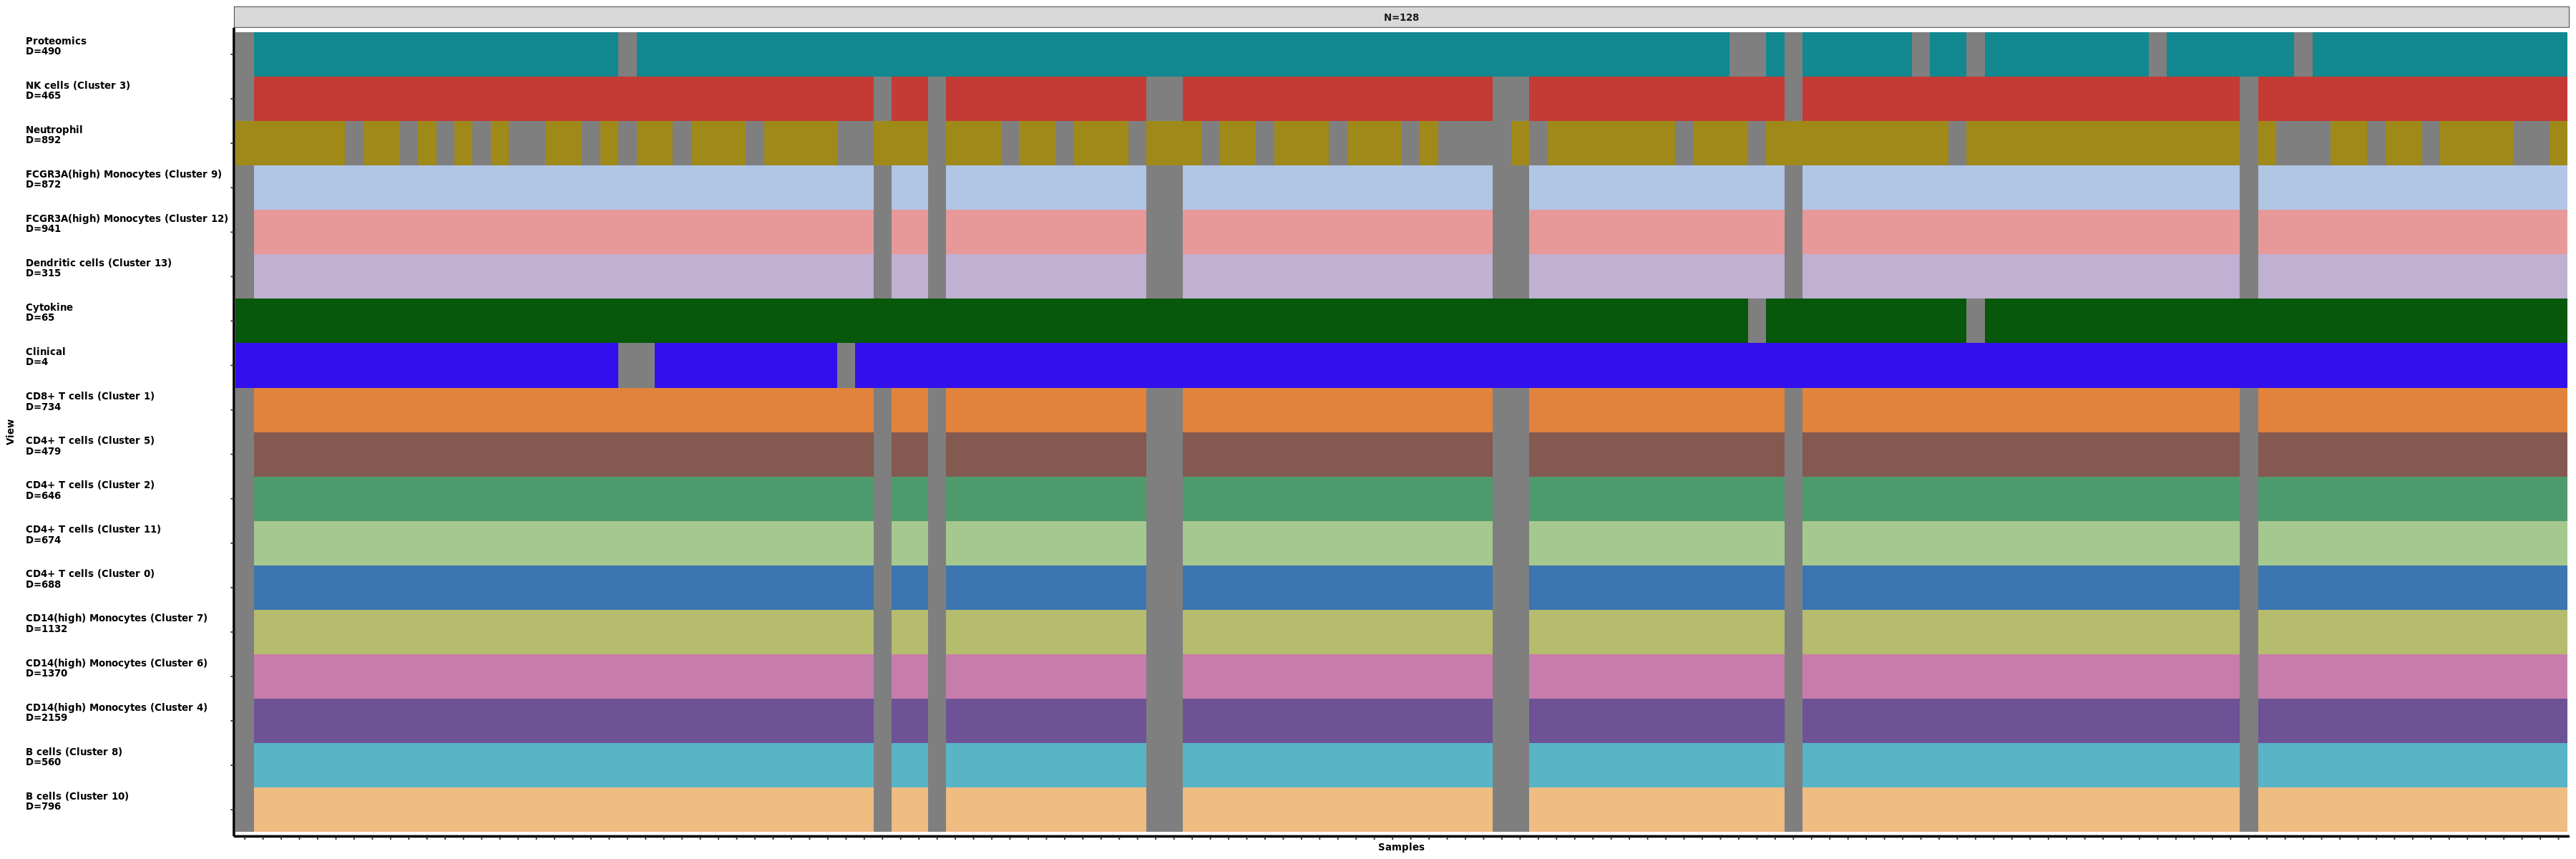

In [79]:
mofa_overview

In [80]:
pdf(paste0('figures/Supplementary_Figures/', figure_name,'_', name,'.pdf'), width =width_par, height = height_par)
print(mofa_overview)
dev.off()

png 
  2

In [81]:
### Use orig MOFA object

In [82]:
MOFAobject = create_mofa(data_list_orig)

Creating MOFA object from a list of matrices (features as rows, sample as columns)...




###  Add covariates for mefisto

In [83]:
MOFAobject

Untrained MOFA model with the following characteristics: 
 Number of views: 18 
 Views names: clinical_data cytokine neutrophil proteomics X0_TcellCD4 X1_TcellCD8 X10_Bcell X11_TcellCD4 X12_MonocytesCD16_FCGR3A X13_Dendritic X2_TcellCD4 X3_NK X4_MonocytesCD14 X5_TcellCD4 X6_MonocytesCD14 X7_MonocytesCD14 X8_Bcell X9_MonocytesCD16_FCGR3A 
 Number of features (per view): 4 65 892 490 688 734 796 674 941 315 646 465 2159 479 1370 1132 560 872 
 Number of groups: 1 
 Groups names: group1 
 Number of samples (per group): 128 
 

In [84]:
#cov = as.data.frame(cov)

### Set data options

In [85]:
mefisto_opts = get_default_mefisto_options(MOFAobject)

In [86]:
data_opts = get_default_data_options(MOFAobject)

In [87]:
data_opts

$scale_views
[1] FALSE

$scale_groups
[1] FALSE

$center_groups
[1] TRUE

$use_float32
[1] FALSE

$views
 [1] "clinical_data"            "cytokine"                
 [3] "neutrophil"               "proteomics"              
 [5] "X0_TcellCD4"              "X1_TcellCD8"             
 [7] "X10_Bcell"                "X11_TcellCD4"            
 [9] "X12_MonocytesCD16_FCGR3A" "X13_Dendritic"           
[11] "X2_TcellCD4"              "X3_NK"                   
[13] "X4_MonocytesCD14"         "X5_TcellCD4"             
[15] "X6_MonocytesCD14"         "X7_MonocytesCD14"        
[17] "X8_Bcell"                 "X9_MonocytesCD16_FCGR3A" 

$groups
[1] "group1"

In [88]:
data_opts$scale_views = TRUE # decide whether to scale the data

In [89]:
## Define model options

In [90]:
model_opts = get_default_model_options(MOFAobject)
model_opts

$likelihoods
           clinical_data                 cytokine               neutrophil 
              "gaussian"               "gaussian"               "gaussian" 
              proteomics              X0_TcellCD4              X1_TcellCD8 
              "gaussian"               "gaussian"               "gaussian" 
               X10_Bcell             X11_TcellCD4 X12_MonocytesCD16_FCGR3A 
              "gaussian"               "gaussian"               "gaussian" 
           X13_Dendritic              X2_TcellCD4                    X3_NK 
              "gaussian"               "gaussian"               "gaussian" 
        X4_MonocytesCD14              X5_TcellCD4         X6_MonocytesCD14 
              "gaussian"               "gaussian"               "gaussian" 
        X7_MonocytesCD14                 X8_Bcell  X9_MonocytesCD16_FCGR3A 
              "gaussian"               "gaussian"               "gaussian" 

$num_factors
[1] 15

$spikeslab_factors
[1] FALSE

$spikeslab_weights
[1] TRUE

$ard_factors
[1] FALSE

$ard_weights
[1] TRUE

In [92]:
model_opts$num_factors = 25 # define number of factors
# TEST different variations: 5,10,15, 25 to generate diff MOFA models with diff amount of factors

In [93]:
#model_opts$likelihoods

### Define training options

In [94]:
train_opts  = get_default_training_options(MOFAobject)
train_opts

$maxiter
[1] 1000

$convergence_mode
[1] "fast"

$drop_factor_threshold
[1] -1

$verbose
[1] FALSE

$startELBO
[1] 1

$freqELBO
[1] 5

$stochastic
[1] FALSE

$gpu_mode
[1] FALSE

$seed
[1] 42

$outfile
NULL

$weight_views
[1] FALSE

$save_interrupted
[1] FALSE

In [95]:
train_opts$maxiter = 50000

In [96]:
train_opts$verbose = TRUE

In [97]:
train_opts$seed = 42

In [98]:
train_opts$weight_views = FALSE

### Stochastic Options

In [99]:
stoch_options = get_default_stochastic_options(MOFAobject)

In [100]:
stoch_options

$batch_size
[1] 0.5

$learning_rate
[1] 1

$forgetting_rate
[1] 0.5

$start_stochastic
[1] 1

### Build and train the model

In [101]:
MOFAobject = prepare_mofa(
  object = MOFAobject,
  data_options = data_opts,
  model_options = model_opts,
  mefisto_options = mefisto_opts,
  training_options = train_opts #,
  #stochastic_options = stoch_options
)

Warning message in prepare_mofa(object = MOFAobject, data_options = data_opts, model_options = model_opts, :
“Some view(s) have less than 15 features, MOFA will have little power to to learn meaningful factors for these view(s)....”
Checking data options...

Checking training options...

Checking model options...



### Save the model

In [102]:
train_opts$weight_views

[1] FALSE

In [103]:
name

[1] "V_FINAL_INTEGRATED"

In [104]:
model_name = paste0("MOFA_MODEL_FACTOR_TEST_", name, '-', train_opts$weight_views,model_opts$num_factors,'.hdf5') # added number of factors in review to test different 

In [105]:
model_name

[1] "MOFA_MODEL_FACTOR_TEST_V_FINAL_INTEGRATED-FALSE25.hdf5"

In [106]:
outfile = file.path( paste0(result_path, '/E-Analysis/',  model_name) )

In [107]:
#outfile

In [797]:
MOFAobject.trained = run_mofa(MOFAobject, outfile, use_basilisk = FALSE)

Connecting to the mofapy2 python package using reticulate (use_basilisk = FALSE)... 
    Please make sure to manually specify the right python binary when loading R with reticulate::use_python(..., force=TRUE) or the right conda environment with reticulate::use_condaenv(..., force=TRUE)
    If you prefer to let us automatically install a conda environment with 'mofapy2' installed using the 'basilisk' package, please use the argument 'use_basilisk = TRUE'


Warning message in run_mofa(MOFAobject, outfile, use_basilisk = FALSE):
“The latest mofapy2 version is 0.6.4, you are using 0.7.0. Please upgrade with 'pip install mofapy2'”
Warning message in run_mofa(MOFAobject, outfile, use_basilisk = FALSE):
“mofapy2_0.6.4 is not detected in the specified python binary, see reticulate::py_config(). Setting use_basilisk = TRUE...”
Connecting to the mofapy2 package using basilisk. 
    Set 'use_basilisk' to FALSE if you prefer to manually set the python binary using 'reticulate'.

Warning message i

In [108]:
nrow(sample_data)

[1] 149

In [109]:
length(unique(sample_data$sample_id))

[1] 149